In [40]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge


from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

# **Outline**

- [**1. Data preparation**](#1-data-preparation)
- [**2. pearson's correlation coefficient**](#2-pearsons-correlation-coefficient)
- [**3. Data Splitting**](#3-data-splitting)
- [**4. Entropy**](#4-entropy)
    - [**4.1 Conditional Entropy**](#41-conditional-entropy)
    - [**4.2 Mutual information**](#42-mutual-information)
- [**5. Logistic Regression**](#5-logistic-regression)



# **1. Data preparation**

Download it from: 

```bash
    wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

**Features**


* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`,
* `MSRP`

In [41]:
df = pd.read_csv('data/car_price.csv')
df.head(2)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


* Select only the features from above and transform their names using the next line:
  
  ```python
    data.columns = data.columns.str.replace(' ', '_').str.lower()
  ```
* Fill in the missing values of the selected features with 0.
* Rename `MSRP` variable to `price`.

In [42]:
# Feature selection

features = ['Make', 'Model', 'Year', 'Engine HP',
            'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
            'highway MPG', 'city mpg', 'MSRP']

df = df[features]


df.columns = df.columns.str.lower()\
                           .str.replace(' ','_')

df.head(2)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650


In [43]:
# Missing values
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [44]:
# Rename target column and fill missing values with zero
df.rename(columns= {'msrp':'price'}, inplace = True)
df[['engine_hp', 'engine_cylinders']] = df[['engine_hp', 'engine_cylinders']].fillna(0)

In [45]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


- **Question 1**

What is the most frequent observation (mode) for the column `transmission_type`?

  - **`AUTOMATIC`**
  - `MANUAL`
  - `AUTOMATED_MANUAL`
  - `DIRECT_DRIVE`


In [46]:
df.groupby('transmission_type')['transmission_type'].count().sort_values(ascending= False)

transmission_type
AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: transmission_type, dtype: int64

# **2. pearson's correlation coefficient**

Pearson's correlation coefficient can be used as a measure of the linear correlation or dependence between two variables, X and Y. The coefficient provides a value between $[1, −1]$, where:

- 1 is a total positive linear correlation, 
- 0 is no linear correlation
- −1 is a total negative linear correlation. 

the correlation for a pair of random variables $(X, Y)$ is given by:

$$
\rho(X,Y) = \frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y}
$$

In this equation, $\text{cov}(X,Y)$ represents the covariance between X and Y, while $\sigma_X$ and $\sigma_Y$ are the standard deviations of X and Y, respectively. The covariance, a measure of how much two random variables change together, is computed as follows:

$\text{cov}(X,Y) = E[(X - E[X])(Y - E[Y])]$

Here, $E[X]$ and $E[Y]$ are the expected values (or means) of X and Y, respectively. This formula essentially captures the joint variability of X and Y.

The standard deviations, which measure the dispersion or spread of the data points from the mean, are computed as follows:

$$\sigma_X = \sqrt{E[X^2] - E[X]^2}$$
$$\sigma_Y = \sqrt{E[Y^2] - E[Y]^2}$$

pearson's correlation coefficient can be a valuable tool to understand and visualize the linear relationships between features. This can inform feature selection, as highly correlated features often carry redundant information

In [47]:
def pearson_corr_matrix(df):

    # Select numeric features
    is_numeric = df.dtypes != 'object'
    numerical = list(df.dtypes[is_numeric].index)
    
    n = len(numerical)
    corr_matrix = np.zeros((n, n))

    for i, feature_i in zip(range(n), numerical ):
        for j, feature_j in zip(range(n), numerical ):
            # Select numerical features x and y
            x = df[feature_i]
            y = df[feature_j]

            # compute the means 
            mean_x = np.mean(x)
            mean_y = np.mean(y)

            # Compute the covariance
            cov_XY = np.mean((x - mean_x) * (y - mean_y))
            # Compute the standard deviations
            std_X = np.sqrt(np.mean((x - mean_x)**2))
            std_Y = np.sqrt(np.mean((y - mean_y)**2))
            
            # Compute the correlation of features x and y
            corr_matrix[i, j] = cov_XY / (std_X * std_Y)
    
    return pd.DataFrame(corr_matrix, index=numerical, columns=numerical)

- **Question 2**

Create the correlation matrix for the numerical features of your dataset. 
In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

- `engine_hp` and `year`
- `engine_hp` and `engine_cylinders`
- `highway_mpg` and `engine_cylinders`
- **`highway_mpg` and `city_mpg`**


In [48]:
correlation_matrix = pearson_corr_matrix(df)
correlation_matrix

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,price
year,1.000000,0.338714,-0.040708,0.258240,0.198171,0.227590
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918,0.650095
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306,0.526274
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829,-0.160043
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000,-0.157676
price,0.227590,0.650095,0.526274,-0.160043,-0.157676,1.000000


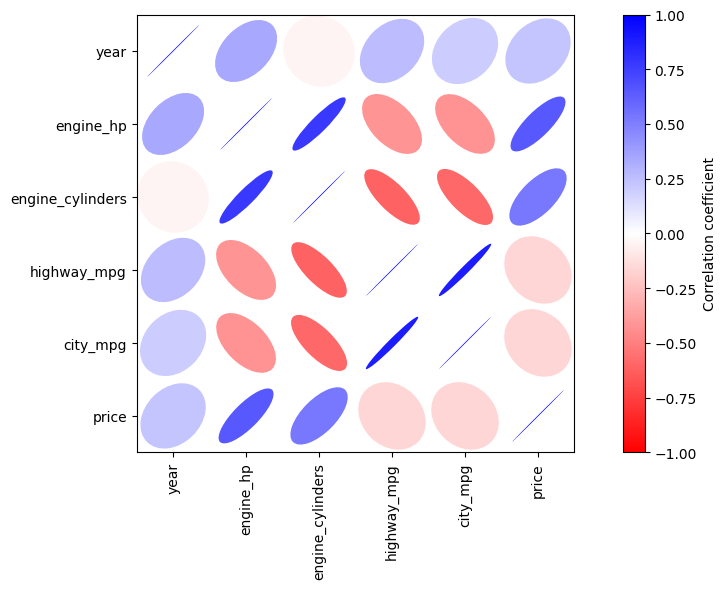

In [49]:
def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax

m, ax = plot_corr_ellipses(correlation_matrix, figsize=(10, 6), cmap='bwr_r')
cb = plt.colorbar(m, ax=ax)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()


we have created a correlation matrix for the numerical features of our dataset. In this matrix, the correlation coefficient between every pair of features in the dataset is computed, which helps in identifying the linear relationship between the features.

By analyzing the correlation matrix  in a heat map, it is clear that the two features `highway_mpg` and `city_mpg` are highly correlated, with correlation value $\rho = 0.886829$ .

# **3. Data Splitting**

To prepare our data for logistic regression, which requires a binary target variable, let's convert the `price` variable into a binary format. We'll introduce a new variable, `above_average`, that will be set to 1 if the price exceeds its average value, and 0 if it doesn't.

In [50]:
avg_price = df['price'].mean()
above_avg = df['price'] > avg_price

#1: True
#0: False
df['above_avg'] = above_avg.astype(int)

display(df[['price', 'above_avg']].head())
print('Average:', round(avg_price, 0))

,price,above_avg
0,46135,1
1,40650,1
2,36350,0
3,29450,0
4,34500,0


Average: 40595.0


Let's split our data in train/val/test sets with 60%/20%/20% distribution.

In [51]:
n = len(df)
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = int(0.6*n)

# shuffle indices
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)
# subset rows by indices
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

Y_train = df_train.above_avg.values
Y_val = df_val.above_avg.values
Y_test = df_test.above_avg.values

Y_train_log = np.log1p(df_train.price.values)
Y_val_log = np.log1p(df_val.price.values)
Y_test_log = np.log1p(df_test.price.values)

# To avoind accidentally using the target variables
for feature in ['above_avg', 'price']:
    del df_train[feature]
    del df_val[feature]
    del df_test[feature]

# **4. Entropy**




Consider a hypothetical dataset with multiple features $\mathbf{X_{1}},\cdots \mathbf{X_{l}}, \cdots, \mathbf{X_{d}}$ and a target variable $\mathbf{Y}$. The target variable and some of these features are categorical, meaning each unique value within them corresponds to a distinct category or event.

$$
\left( \begin{array}{c|ccccc|c}
\text{Instance} & \mathbf{X_{1}} & \cdots & \mathbf{X_{l}} & \cdots & \mathbf{X_{d}} & \mathbf{Y} \\
\hline
\mathbf{x_{1}} & x_{11} & \cdots & x_{1l} & \cdots & x_{1d} & y_1 \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots \\
\mathbf{x_{n}} & x_{n1} & \cdots & x_{nl} & \cdots & x_{nd} & y_n \\
\end{array} \right).
$$

Here, each row vector $ \mathbf{x}_i = (x_{i1}, \ldots, x_{id}) $ represents an instance of the dataset with $ d $ values. We take from this dataset one feature vector $\mathbf{X}_l$ with categorical values and a target vector $\mathbf{Y}$ as follows:


$$\mathbf{X}_l= \left( \begin{array}{c}
x_{1l}\\
\vdots\\
x_{nl}
\end{array} \right)  ~~~~~

\mathbf{Y} = \left( \begin{array}{c}
y_1\\
\vdots\\
y_n
\end{array} \right)
$$

The concept of entropy arises from information theory. It is a measure that captures the amount of uncertainty or randomness in a variable. 

When considering a categorical feature $ \mathbf{X}_l $ as a random variable, entropy helps us understand the unpredictability in the unique categories it can adopt. Let's denote the set of unique categories in $ \mathcal{X}=  \{a_1, a_2, \ldots, a_k\} $ where $ k $ is the number of unique categories. If the probabilities of these categories occurring are $ p(a_1), p(a_2), \ldots, p(a_k) $, then the entropy $ H(\mathbf{X}_l) $ is given by:


$$H(\mathbf{X}_l) = \mathbb{E}_{x \in \mathcal{X}}[-\log{p(x)}] = -\sum_{x \in \mathcal{X}} p(x)\log{p(x)} $$

The formula includes a negative sign to guarantee a non-negative entropy value. In the context of data analysis, a feature with high entropy implies a greater diversity in the distribution of its categories, leading to a decrease in prediction certainty. On the other hand, low entropy indicates a degree of homogeneity in its classes, making the feature values more predictable (less random).

From the entropy formula, we can think $ H(\mathbf{X}_l) $ as encapsulating the expected uncertainty experienced when a value from $ \mathbf{X}_l $ is observed. Each category $x$ in $ \mathcal{X} $ has an associated information content — or uncertainty factor — given by $ p(x)\log{p(x)} $. By taking the expected value across all categories, entropy essentially calculate the expected level of uncertainty.


## **4.1 Conditional Entropy**



Conditional entropy extends the concept of entropy to measure the unpredictability of one variable, given knowledge about another. In this context, we wish to understand this with respect to our feature vector $ \mathbf{X}_l $ and target vector $ \mathbf{Y} $.


Instead of using the ordinary probability $ p(x) $ as before, we can use the conditional probability. Let's denote the set of unique categories from $\mathbf{Y}$ as $ \mathcal{Y} =  \{b_1, b_2, \ldots, b_m\} $ with the probabilities of these categories occurring being $ p(b_1), p(b_2), \ldots, p(b_m) $. Then, the conditional probability is denoted as $p(\mathbf{X}_l|\mathbf{Y} = y)$. Given this, we can compute the conditional entropy of $\mathbf{X}_l$ for a fixed state $ y \in \mathcal{Y}$ as:
 

$$H(\mathbf{X}_l|\mathbf{Y} = y) = \mathbb{E}_{x \in \mathcal{X}}[-\log{p(x|y)}] = - \sum_{x \in \mathcal{X}} p(x|y)\log p(x|y) $$

To relate this to joint probabilities, consider the following definitions:

---

- **Joint probability**:Let $x \in \mathcal{X} = \{a_1, a_2, \ldots, a_k\} $ and $y \in \mathcal{Y} = \{b_1, b_2, \ldots, b_m\} $. If $N(x)$ symbolizes the count of occurrences of event $x$, and $N(x \cap y)$ the simultaneous occurrence of events $x$ and $y$, the joint probability can be formulated as:

    $$
    p(x \cap y) = \frac{N(x \cap y)}{N}
    $$

    Here, $N $ is the total number of events.

- **Conditional probability**:
    It describes the probability of event $x$ occurring given that event $y$ has already occurred. The conditional probability of event $x$ given event $y$ is then defined as:

    $$p(x|y) = \frac{p(x \cap y)}{p(y)}.$$

    where $p(y)$ is the ordinary probability of some event $y$ happening,

    $$p(y) = \frac{N(y)}{N}.$$
---

Given theses briefly definition, we can use the following relationship,

$$p(x|y) = \frac{p(x \cap y )}{p(y)},$$

to express the conditional entropy as:

$$H(\mathbf{X}_l|y) = - \sum_{x \in \mathcal{X}} \frac{p(x \cap y)}{p(y)}\log \bigg(\frac{p(x \cap y)}{p(y)}\bigg) $$ 

Here we simplified the notation of entropy $H(\mathbf{X}_l|\mathbf{Y} = y)$ to $H(\mathbf{X}_l|y)$. 

To fully evaluate the conditional entropy across all values of $\mathbf{Y}$, we can take again the expectation value over all possible values from $\mathbf{Y}$, as we did before for values of $\mathbf{X}_l$. Given the expected value we get:

$$ \mathbb{E}_{y \in \mathcal{Y}}[H(\mathbf{X}_l| y)] = H(\mathbf{X}_l|\mathbf{Y}) = - \sum_{{y \in \mathcal{Y}}} p(y)H(\mathbf{X}_l|y) $$


substituting $H(\mathbf{X}_l| y)$ into the equation, we get:

$$
\begin{align*}
H(\mathbf{X}_l|\mathbf{Y}) &= - \sum_{y \in \mathcal{Y}} p(y)H(\mathbf{X}_l|y) \\
       &= - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(y)\bigg[\frac{p(x \cap y)}{p(y)}\log \bigg(\frac{p(x \cap y)}{p(y)}\bigg)\bigg]\\
       &= - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x \cap y)\log \bigg(\frac{p(x \cap y)}{p(y)}\bigg)
\end{align*}
$$

This computation yields the expected conditional entropy over all possible outcomes of $\mathbf{Y}$. But this equation can be further rearranged using logarithm properties to obtain:


$$
\begin{align*}
H(\mathbf{X}_l|\mathbf{Y}) &= - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} \bigg[ p(x \cap y)\log{p(x \cap y)} -    p(x \cap y)\log{p(y)}\bigg] \\
    &= - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}  p(x \cap y)\log{p(x \cap y)} +\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}    p(x \cap y)\log{p(y)}\\
    &= H(\mathbf{X}_l \cap \mathbf{Y}) + \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}    p(x \cap y)\log{p(y)}

\end{align*}
$$

Now, for the second summation term, from the law of total probability, we have

$$p(y) = \sum_{x \in \mathcal{X}} p(x|y)p(y)$$

then, using one more time the relationship $p(x \cap y ) = p(x|y)p(y) $  and the total law 

$$
\begin{align*}
H(\mathbf{X}_l|\mathbf{Y}) &= H(\mathbf{X}_l \cap \mathbf{Y}) + \sum_{y \in \mathcal{Y}} \bigg[\sum_{x \in \mathcal{X}} p(x|y)p(y)\bigg] \log{p(y)}\\
       & = H(\mathbf{X}_l \cap \mathbf{Y}) +  \sum_{y \in \mathcal{Y}}p(y)\log{p(y)}
\end{align*}
$$

The second term simplify to the negative entropy $-H(\mathbf{Y})$

$$H(\mathbf{X}_l|\mathbf{Y}) = H(\mathbf{X}_l \cap \mathbf{Y} ) - H(\mathbf{Y}) $$


This represents the expected uncertainty about $\mathbf{X}_l$ once knowledge about $\mathbf{Y}$ is accounted for.

## **4.2 Mutual information**

Mutual information was introduced to quantify how much information knowing one variable gives about another.

A straightforward way to think about this is to measure how much the entropy (uncertainty) of $\mathbf{X}_l$  reduces when $\mathbf{Y}$ is known. This is given by the difference between the entropy of $\mathbf{X}_l$ and the conditional entropy of $\mathbf{X}_l$ given $\mathbf{Y}$:

$$MI(\mathbf{X}_l;\mathbf{Y}) = H(\mathbf{X}_l) − H(\mathbf{X}_l|\mathbf{Y})$$

Thus mutual information quantifies the amount of information gained about $\mathbf{X}_l$ after learning about $\mathbf{Y}$, and the amount of information gained about $\mathbf{Y}$ after learning about $\mathbf{X}_l$. This is because mutual information is symmetric, i.e., $MI(\mathbf{X}_l;\mathbf{Y}) = MI(\mathbf{Y};\mathbf{X}_l)$.

Here's how to interpret mutual information:

- **If $MI(\mathbf{X}_l;\mathbf{Y})$ is high:** A high value of mutual information means a value closer to  $H(\mathbf{X}_l)$ or $H(\mathbf{Y})$.  knowing $\mathbf{Y}$ reduces our uncertainty about $\mathbf{X}_l$, and knowing $\mathbf{X}_l$ reduces our uncertainty about $\mathbf{Y}$. This is the case where $\mathbf{X}_l$ and $\mathbf{Y}$ have some dependency.
 
- **If $MI(\mathbf{X}_l;\mathbf{Y})$ is zero:**  knowing $\mathbf{Y}$ does nothing to decrease our uncertainty about $\mathbf{X}_l$, and knowing $\mathbf{X}_l$ does nothing to decrease our uncertainty about $\mathbf{Y}$. This is the case when $\mathbf{X}_l$ and $\mathbf{Y}$ are independent.

- **Question 3**

    * Calculate the mutual information score between `above_average` and other categorical variables in our dataset. 
      Use the training set only.
    * Round the scores to 2 decimals using `round(score, 2)`.

    Which of these variables has the lowest mutual information score?
      
    - `make`
    - `model`
    - **`transmission_type`**
    - `vehicle_style`

In [52]:
def  entropy_metrics(feature, target):

    def entropy(feature):

        unique, n_x = np.unique(feature, return_counts= True)
        n = len(feature)
        p_x = n_x/n
        # Only consider non-zero probabilities to avoid log(0)
        p_x = p_x[p_x > 0]
        H_x = -np.sum(p_x * np.log(p_x))
        return H_x

    def joint_entropy(feature, target):
        
        # frequency distribution of their joint occurrences.
        joint_freq = pd.crosstab(feature, target)
        # .sum().sum() calculate total sum across both rows and columns.
        n = joint_freq.sum().sum()
        # joint probabilities by dividing each frequency by the total count
        joint_prob = joint_freq/n
        # Sum across rows and columns for the final joint entropy value.
        joint_entropy = - np.sum(np.sum(joint_prob[joint_prob > 0] * np.log(joint_prob[joint_prob > 0])) )
        
        return joint_entropy

    def conditional_entropy(feature, target):
        return joint_entropy(feature, target) - entropy(target)
    

    def mutual_info(feature, target):
        return entropy(feature) -  conditional_entropy(feature, target)
    
    results = {
        'entropy': entropy(feature),
        'joint_entropy': joint_entropy(feature, target),
        'conditional_entropy': conditional_entropy(feature, target),
        'mutual_information': mutual_info(feature, target)
    }

    return results


In [53]:
# Select categorical features
is_categorical = df_train.dtypes == 'object'
categorical = list(df_train.dtypes[is_categorical].index)

# Create an empty list to store results
mi_results = []
for feature in categorical:
    metric = entropy_metrics(df_train[feature], df['above_avg'])
    # Append a tuple containing feature name and its mutual info
    mi_results.append((feature, round(metric['mutual_information'], 2)))

mutual_info_df = pd.DataFrame(mi_results, columns=['mutual_info', 'above_avg']).sort_values(by = 'above_avg',ascending=True)

display(mutual_info_df)

,mutual_info,above_avg
2,transmission_type,0.02
3,vehicle_style,0.08
0,make,0.24
1,model,0.46


# **5. Logistic Regression**



Consider a hypothetical dataset with multiple features $\mathbf{X}_{1},\cdots, \mathbf{X}_{d}$ and a target variable $\mathbf{Y}$ as shown:

$$
\left( \begin{array}{c|cccc|c}
\text{Instance}    &\mathbf{X}_{0}&\mathbf{X}_{1}&\cdots & \mathbf{X}_{d}  & \mathbf{Y}\\
\hline
\mathbf{x}_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

Here, each row vector is an instance $ \mathbf{x}_i = (1, x_{i1}, \ldots, x_{id}) $ of the dataset with $ d+1 $ values. The first column, $ \mathbf{X}_0 $, is the intercept term (or bias) and is set to $1$ for all instances. The dataset is separated in a feature matrix $\mathbf{X}$ and a binary target vector $\mathbf{Y}$:


$$\mathbf{X}=
\left( \begin{array}{cccc}
 1& x_{11}& \cdots&x_{1d} \\
\vdots&\vdots&\ddots&\vdots&\\
1&x_{n1}&\cdots&x_{nd}
\end{array} \right) ~~~ \text{and} ~~~ 

\mathbf{Y} = \left( \begin{array}{c}
y_1\\
\vdots\\
y_n
\end{array} \right)
$$

The target vector $\mathbf{Y}$ consists of binary values, either 0 or 1, hence forming the set $\mathcal{Y}=\{0,1\}$.

Since there are only two possible unique values for $Y$, the conditional probabilities can be defined as:

$$p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \pi( \mathbf{x}_i) ~~\text{and}~~~p(\mathbf{Y} = 0|\mathbf{X}= \mathbf{x}_i) = 1- \pi( \mathbf{x}_i)$$

This notation indicates that we're looking at the conditional probability of $ \mathbf{Y} $ being 1 given a specific instance $ \mathbf{x}_i $. Here, $ \pi( \mathbf{x}_i) $ represents an unknown function of the instances. Our primary objective in logistic regression is to estimate this function, $ \pi( \mathbf{x}_i) $, which essentially defines our logistic regression model.

A naive approach would be to directly use linear regression for the function $ \pi( \mathbf{x}_i) = \mathbf{x}_i\mathbf{w}$, where $\mathbf{w} = (w_0, \ldots, w_d)^T$ is the weights that will be learned by the model. This would  result in

$$p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \mathbf{x}_i\mathbf{w}.$$

However due to the fact that $\mathbf{x}_i\mathbf{w}$ can assume values in the range $(- \infty,+ \infty)$ is not possible to use as a probability model. We require that the output represents a probability values, and thus we need a model that results in an output that lies in the range $[0,1]$. For this task we rely in the sigmoid function, this function is also know as logistic function. The logistic function is defined as follows:

---

- **Sigmoid**
    $$\theta(z) = \frac{1}{1+e^{-z}} = \frac{e^{z}}{1+e^{z}}$$

    for any $z \in \mathbb{R}$ the output is $\theta(z) \in [0,1]$. An interesting property of the logistic function is that $1 - \theta(z) = \theta(-z)$:

$$1-\theta(z) = 1 - \frac{1}{1+ e^{-z}} = \frac{e^{-z}}{1+ e^{-z}} = \frac{1}{1+ e^{z}} =  \theta(-z)~~\square$$
---
We now can maps this linear combination $\mathbf{x}_i\mathbf{w}$ through the logistic (sigmoid) function to get a value that represents a probability between 0 and 1. We can address the probability as $p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w})$ and define the logistic regression model as follows:

$$
\begin{align*}
p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i) &= \theta(\mathbf{x}_i\mathbf{w}) \\
&= \frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}~~~\text{and}\\
\\
p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i) &= 1 - p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i)\\
&= \frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\\
& = \theta(-\mathbf{x}_i\mathbf{w})
\end{align*}
$$

where in $p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i)$ we use the property $1 - \theta(z) = \theta(-z)$. The model then can be formulated from the following probability:

$$p(\mathbf{Y}|\mathbf{X} = \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w})^{y}\theta(-\mathbf{x}_i\mathbf{w})^{1-y}$$

where $y \in \mathcal{Y} = \{0,1\}$, which can be considered a Bernoulli random variable that takes on either the values 0 or 1. We can observe that 


$$ p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w}) ~~\text{and} ~~ p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i) = \theta(-\mathbf{x}_i\mathbf{w})$$ 

**Maximum Likelihood Estimation**

In logistic regression, we use the maximum likelihood estimation (MLE) approach to find the optimal weight vector, $ \mathbf{w} = (w_0, \ldots, w_d)^T $. The likelihood function quantifies how well our model, parameterized by $ \mathbf{w} $, explains the observed data. Consider the joint probability of observing the entire target vector $ \mathbf{Y} $ given the feature matrix $ \mathbf{X} $ under a particular parametrization $ \mathbf{w} $:

$$ \mathcal{L}(\mathbf{w}) = p(\mathbf{Y}|\mathbf{X}; \mathbf{w} ) = P(y_1, \ldots, y_n|\mathbf{x}_1, \ldots, \mathbf{x}_n; \mathbf{w} ) $$

If we assume that the observed outcomes in vector $\mathbf{Y}$, given their corresponding features in matrix $\mathbf{X}$, are conditionally independent given the model parameters $\mathbf{w}$, then we can factorize the likelihood of the entire dataset as the product of the likelihoods of each individual observation:

$$ \mathcal{L}(\mathbf{w}) = \prod_{i=1}^{n} P(y_i|\mathbf{x}_i; \mathbf{w} )  $$

Each term $ P(y_i|\mathbf{x}_i; \mathbf{w} ) $ represents the probability that instance $ i $ belongs to its observed class given its features and the model parameters. Substituting the logistic model into the likelihood we get

$$\mathcal{L}(\mathbf{w}) =  \prod_{i = 1}^{n} \theta(\mathbf{x}_i\mathbf{w})^{y_i}\theta(-\mathbf{x}_i\mathbf{w})^{1-y_i}$$

Our aim is to find the value of $\mathbf{w}$ that maximizes this likelihood, an approach known as Maximum Likelihood Estimation (MLE). In practice, we often maximize the logarithm of the likelihood (log-likelihood) to convert the product into a sum:

$$
\begin{align*}
\log(\mathcal{L}(\mathbf{w})) & = \log \left(\prod_{i = 1}^{n} \theta(\mathbf{x}_i\mathbf{w})^{y_i}\theta(-\mathbf{x}_i\mathbf{w})^{1-y_i}\right) \\
& = \sum_{i = 1}^{n} y_i\log(\theta(\mathbf{x}_i\mathbf{w})) + (1-y_i)\log(\theta(-\mathbf{x}_i\mathbf{w}))
\end{align*}
$$

Substituting the logistic function into this equation further simplifies it:

$$\log(\mathcal{L}(\mathbf{w})) = \sum_{i = 1}^{n} y_i\log \left(\frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}\right) + (1-y_i)\log \left(\frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\right)$$

Typically in optimization, we don't maximize this log-likelihood directly. Instead, we minimize the negative of this quantity, which is called the log-loss or binary cross-entropy loss function. This function serves as a loss function during training:

$$\text{loss}(\mathbf{w}) = -\log(\mathcal{L}(\mathbf{w})) = -\sum_{i = 1}^{n} y_i\log \left(\frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}\right) - (1-y_i)\log \left(\frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\right)$$

This binary cross-entropy loss comes directly from the negative log-likelihood of the Bernoulli distribution, and this is why it's appropriate for binary classification problems like this one. It measures the dissimilarity between the ground-truth labels and the predicted probabilities. The better our predictions, the lower the cross-entropy loss.

To obtain the optimal weights vector $\mathbf{w}$, we would typically differentiate the log-likelihood function with respect to $\mathbf{w}$, equate the result to zero, and then solve for $\mathbf{w}$. However, unlike linear regression, the log-likelihood formulation lacks a closed form solution for the weight vector. Instead, we use methods like gradient ascent due to the concavity of the log-likelihood function, which ensures a unique global maximum. After calculating the optimal weights, we can use the model equation to make prediction:


$$P(\mathbf{Y} = y|\mathbf{X} = \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w})^{y}\theta(-\mathbf{x}_i\mathbf{w})^{1-y}$$

where $y \in \mathcal{Y}$.


- **Question 4**

  * Now let's train a logistic regression.
  * Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
  * Fit the model on the training dataset.
      - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
      - `model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)`
  * Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

- 0.60
- 0.72
- 0.84
- **0.95**



**One-Hot Encoding**

When dealing with a categorical variable like with multiple unique values, we can use a technique called one-hot encoding to represent each value as a binary vector.

This encoding scheme works by designating the "active" or "hot" value as 1, while the other values are considered "not active" or "cold" and assigned a value of 0. 

In [54]:
# one hot encoding for train set
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

# one hot encoding for validation set
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Training model
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, Y_train)


# Model probability prediction on validation set
Y_pred_prob = model.predict_proba(X_val)[:, 1]


# Dataframe with results
Y_pred = (Y_pred_prob >= 0.5).astype(int)
dict_df = {'probability': Y_pred_prob , 'prediction': Y_pred,
        'actual': Y_val  }
df_results = pd.DataFrame(dict_df)

display(df_results)

total_accuracy = (Y_val == Y_pred).mean()
print('Accuracy', round(total_accuracy, 2))

,probability,prediction,actual
0,0.004305,0,0
1,0.010939,0,0
2,0.015169,0,0
3,0.551635,1,1
4,0.004655,0,0
...,...,...,...
2377,0.004285,0,0
2378,0.011130,0,0
2379,0.031702,0,0
2380,0.008463,0,0


Accuracy 0.94


- **Question 5**

    * Let's find the least useful feature using the *feature elimination* technique.
    * Train a model with all these features (using the same parameters as in Q4).
    * Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
    * For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 

Which of following feature has the smallest difference?

- **`year`**
- `engine_hp`
- `transmission_type`
- `city_mpg`

In [55]:
eliminated_features = []
accuracies = []
accuracy_diffs = []

for feature in df_train.columns:
    # one hot encoding train and validation sets
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.drop(feature, axis = 1)\
                            .to_dict(orient = 'records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.drop(feature, axis = 1)\
                        .to_dict(orient='records')
    X_val = dv.transform(val_dict)

    # Train a model without the feature
    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, Y_train)

    # Predict and calculate accuracy
    Y_pred = model.predict(X_val)
    accuracy = (Y_val == Y_pred).mean()

    df_accuracy = pd.DataFrame(columns=['eliminated_feature', 'accuracy', 'accuracy_diff'])

    # Calculate the difference
    difference = round(total_accuracy - accuracy, 3)
    # Store results in lists
    eliminated_features.append(feature)
    accuracies.append(accuracy)
    accuracy_diffs.append(difference)

df_accuracy = pd.DataFrame({
    'eliminated_feature': eliminated_features,
    'accuracy': accuracies,
    'accuracy_diff': accuracy_diffs
}).sort_values(by=['accuracy_diff'], ascending=True)

print('Accuracy for all features:', round(total_accuracy, 2))
display(df_accuracy)

Accuracy for all features: 0.94


,eliminated_feature,accuracy,accuracy_diff
2,year,0.947943,-0.011
4,engine_cylinders,0.939966,-0.003
6,vehicle_style,0.937448,-0.000
8,city_mpg,0.935768,0.001
7,highway_mpg,0.935348,0.002
5,transmission_type,0.933669,0.003
0,make,0.926113,0.011
3,engine_hp,0.913518,0.024
1,model,0.911419,0.026


- **Question 6**

    * For this question, we'll see how to use a linear regression model from Scikit-Learn.
    * We'll need to use the original column `price`. Apply the logarithmic transformation to this column.
    * Fit the Ridge regression model on the training data with a solver `'sag'`. Set the seed to `42`.
    * This model also has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`.
    * Round your RMSE scores to 3 decimal digits.

Which of these alphas leads to the best RMSE on the validation set?

- **0**
- 0.01
- 0.1
- 1
- 10

Let's split again the dataset, this time using the `train_test_split` from Scikit-Learn.

In [56]:
df['price'] = np.log1p(df['price'])

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_log1p = df_train.price.values
y_val_log1p = df_val.price.values
y_test_log1p = df_test.price.values

df_train = df_train.drop('price', axis=1)
df_val = df_val.drop('price', axis=1)
df_test = df_test.drop('price', axis=1)

assert 'price' not in df_train.columns
assert 'price' not in df_val.columns
assert 'price' not in df_test.columns


# Convert datasets to dictionary 
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

# One-hot encode
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)


In [57]:
# Suppress ConvergenceWarning messages from using solver = sag
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


alphas = [0, 0.01, 0.1, 1, 10]
results = []
for alpha in alphas:
    # Instantiate and train the Ridge regression model
    ridge_model = Ridge(alpha=alpha, solver='sag', random_state=42)
    ridge_model.fit(X_train, y_train_log1p)

    # Predict on the validation set
    Y_pred_log1p = ridge_model.predict(X_val)

    # Calculate RMSE
    rmse = mean_squared_error(y_val_log1p, Y_pred_log1p , squared=False)

    results.append({
        'alpha': alpha,
        'rmse': rmse  
    })

df_results = pd.DataFrame(results).sort_values(by = 'rmse', ascending= True)
display(df_results)


,alpha,rmse
0,0.00,0.480205
1,0.01,0.480206
2,0.10,0.480208
3,1.00,0.480229
4,10.00,0.480436
